In [3]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

file_pd = 'sample_submission.csv'
pd_df = pd.read_csv(file_pd)


pd_df.head()

,row_id,article_id,dataset_id,type
0,0,10.1002_2017jc013030,https://doi.org/10.17882/49388,Primary
1,1,10.1002_cssc.202201821,https://doi.org/10.5281/zenodo.7074790,Primary
2,2,10.1002_ece3.4466,https://doi.org/10.5061/dryad.r6nq870,Primary
3,3,10.1002_ece3.5260,https://doi.org/10.5061/dryad.2f62927,Primary
4,4,10.1002_ece3.6144,https://doi.org/10.5061/dryad.zw3r22854,Primary


In [5]:
import os
import xml.etree.ElementTree as ET
import pandas as pd

def extract_text_from_element(elem, skip_tags=("xref", "table-wrap", "fig", "table", "label")):
    """Ekstrak teks dari elemen XML, abaikan tag tertentu"""
    texts = []
    for sub in elem.iter():
        if sub.tag not in skip_tags:
            if sub.text:
                texts.append(sub.text.strip())
            if sub.tail:
                texts.append(sub.tail.strip())
    return " ".join(texts)

def parse_article_xml_clean(xml_path):
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()

        # Ambil article_id dari DOI
        doi_elem = root.find(".//article-id[@pub-id-type='doi']")
        article_id = doi_elem.text.strip().replace("/", "_") if doi_elem is not None else os.path.basename(xml_path).replace(".xml", "")

        # Ambil abstract
        abstract_elem = root.find(".//abstract")
        abstract = extract_text_from_element(abstract_elem) if abstract_elem is not None else ""

        # Ambil body (tanpa xref, figure, table)
        body_elem = root.find(".//body")
        sections = []
        if body_elem is not None:
            for sec in body_elem.findall(".//sec"):
                sec_text = extract_text_from_element(sec)
                if sec_text:
                    sections.append(sec_text)
        body = "\n\n".join(sections)

        return {
            "article_id": article_id,
            "abstract": abstract,
            "body": body,
        }

    except Exception as e:
        print(f"Parsing error in {xml_path}: {e}")
        return None

# 🔧 Sesuaikan path ini jika perlu
xml_folder = "train/XML"

# Proses semua file .xml
parsed_articles = []
for fname in os.listdir(xml_folder):
    if fname.endswith(".xml"):
        full_path = os.path.join(xml_folder, fname)
        article_data = parse_article_xml_clean(full_path)
        if article_data:
            parsed_articles.append(article_data)

# Simpan ke CSV yang rapi
df_xml = pd.DataFrame(parsed_articles)
df_xml.to_csv("parsed_articles_train_clean.csv", index=False)
print("✅ Parsing selesai. Data disimpan ke parsed_articles_train_clean.csv")


✅ Parsing selesai. Data disimpan ke parsed_articles_train_clean.csv


In [11]:
import os
import xml.etree.ElementTree as ET
import pandas as pd

def extract_text_from_element(elem, skip_tags=("xref", "table-wrap", "fig", "table", "label")):
    """Ekstrak teks dari elemen XML, abaikan tag tertentu"""
    texts = []
    for sub in elem.iter():
        if sub.tag not in skip_tags:
            if sub.text:
                texts.append(sub.text.strip())
            if sub.tail:
                texts.append(sub.tail.strip())
    return " ".join(texts)

def parse_article_xml_clean(xml_path):
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()

        # Ambil article_id dari DOI
        doi_elem = root.find(".//article-id[@pub-id-type='doi']")
        article_id = doi_elem.text.strip().replace("/", "_") if doi_elem is not None else os.path.basename(xml_path).replace(".xml", "")

        # Ambil abstract
        abstract_elem = root.find(".//abstract")
        abstract = extract_text_from_element(abstract_elem) if abstract_elem is not None else ""

        # Ambil body (tanpa xref, figure, table)
        body_elem = root.find(".//body")
        sections = []
        if body_elem is not None:
            for sec in body_elem.findall(".//sec"):
                sec_text = extract_text_from_element(sec)
                if sec_text:
                    sections.append(sec_text)
        body = "\n\n".join(sections)

        return {
            "article_id": article_id,
            "abstract": abstract,
            "body": body,
        }

    except Exception as e:
        print(f"Parsing error in {xml_path}: {e}")
        return None

# 🔧 Sesuaikan path ini jika perlu
xml_folder = "test/XML"

# Proses semua file .xml
parsed_articles = []
for fname in os.listdir(xml_folder):
    if fname.endswith(".xml"):
        full_path = os.path.join(xml_folder, fname)
        article_data = parse_article_xml_clean(full_path)
        if article_data:
            parsed_articles.append(article_data)

# Simpan ke CSV yang rapi
df_xml = pd.DataFrame(parsed_articles)
df_xml.to_csv("parsed_articles_test_clean.csv", index=False)
print("✅ Parsing selesai. Data disimpan ke parsed_articles_test_clean.csv")


✅ Parsing selesai. Data disimpan ke parsed_articles_test_clean.csv


In [13]:
import os
import xml.etree.ElementTree as ET
import pandas as pd

# === 1. Ambil dataset link lengkap ===
def extract_dataset_links(root):
    dataset_links = set()

    # Cari <related-object content-type="dataset">
    for ro in root.findall(".//related-object[@content-type='dataset']"):
        href = ro.get("{http://www.w3.org/1999/xlink}href")
        if href:
            dataset_links.add(href.strip())

    # Cari <ext-link> yang mungkin berisi dataset
    for el in root.findall(".//ext-link"):
        href = el.get("{http://www.w3.org/1999/xlink}href")
        if href and is_dataset_link(href):
            dataset_links.add(href.strip())

    return list(dataset_links)

# === 2. Identifikasi apakah link dataset ===
def is_dataset_link(url):
    keywords = ["figshare", "zenodo", "datadryad", "doi"]
    return any(kw in url.lower() for kw in keywords)

# === 3. Path folder XML (TEST) ===
xml_folder = "test/XML"
parsed_labels = {}

# === 4. Proses semua file XML ===
for fname in os.listdir(xml_folder):
    if fname.endswith(".xml"):
        full_path = os.path.join(xml_folder, fname)
        try:
            tree = ET.parse(full_path)
            root = tree.getroot()

            # Ambil article_id (gunakan DOI atau nama file)
            doi_elem = root.find(".//article-id[@pub-id-type='doi']")
            article_id = doi_elem.text.strip().replace("/", "_") if doi_elem is not None else fname.replace(".xml", "")

            # Ambil semua dataset links
            dataset_links = extract_dataset_links(root)
            if dataset_links:
                parsed_labels[article_id] = ",".join(dataset_links)  # Gabungkan jadi string
                print(f"✅ {fname}: {dataset_links}")
            else:
                parsed_labels[article_id] = "unknown"
                print(f"⚠ No dataset found in {fname}")

        except Exception as e:
            print(f"❌ Error parsing {fname}: {e}")

# === 5. Simpan ke CSV ===
df_labels = pd.DataFrame(list(parsed_labels.items()), columns=["article_id", "dataset_id"])
df_labels.to_csv("test_labels.csv", index=False)
print("✅ Done! File saved as test_labels.csv")


⚠ No dataset found in 10.1002_2017jc013030.xml
⚠ No dataset found in 10.1002_anie.201916483.xml
⚠ No dataset found in 10.1002_anie.202005531.xml
✅ 10.1002_anie.202007717.xml: ['https://www.ccdc.cam.ac.uk/services/structures?id=doi:10.1002/anie.202007717']
⚠ No dataset found in 10.1002_chem.201902131.xml
✅ 10.1002_chem.201903120.xml: ['https://www.ccdc.cam.ac.uk/services/structures?id=doi:10.1002/chem.201903120']
⚠ No dataset found in 10.1002_chem.202000235.xml
⚠ No dataset found in 10.1002_chem.202001412.xml
✅ 10.1002_chem.202001668.xml: ['https://www.ccdc.cam.ac.uk/services/structures?id=doi:10.1002/chem.202001668']
✅ 10.1002_chem.202003167.xml: ['https://summary.ccdc.cam.ac.uk/structure-summary?doi=10.1002/chem.202003167']
✅ 10.1002_cssc.202201821.xml: ['https://doi.org/10.5281/zenodo.7074790']
✅ 10.1002_ece3.3985.xml: ['https://doi.org/10.1111/j.1471-8286.2004.00684.x', 'https://doi.org/10.1007/s00265-006-0301-2', 'https://doi.org/10.1111/j.1471-8286.2005.01029.x', 'https://doi.org/

C:\Users\Kahfi\AppData\Local\Temp\ipykernel_23412\214924390.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="type", data=df, palette="viridis")


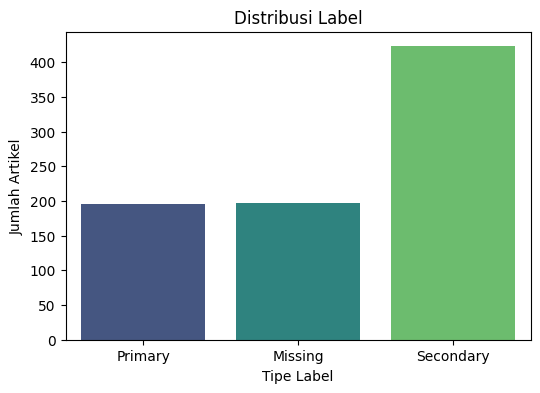


Distribusi Label:
 type
Secondary    423
Missing      197
Primary      195
Name: count, dtype: int64


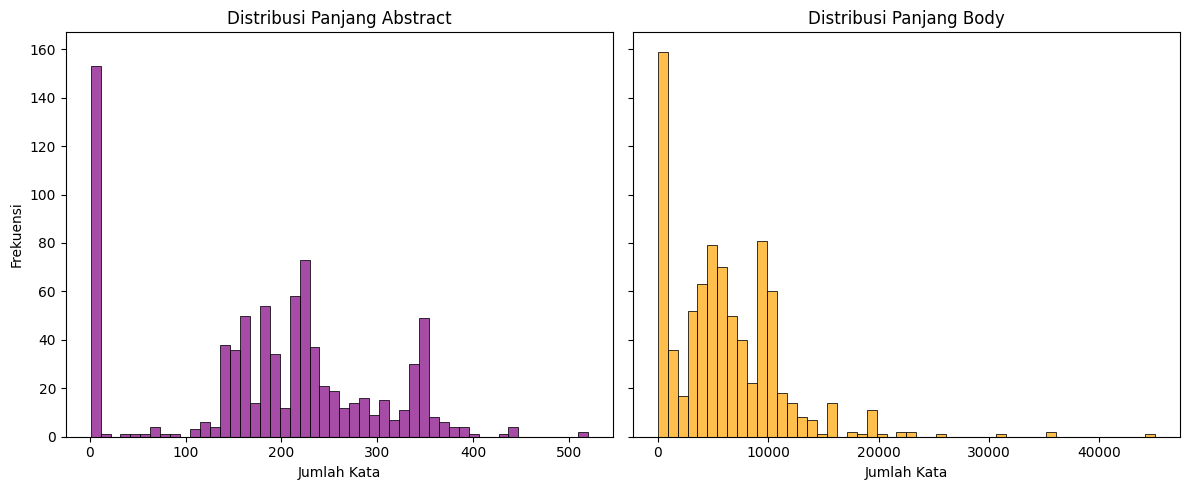


Rata-rata Panjang per Label:
           abstract_length  body_length
type                                   
Missing         251.355330  7916.573604
Primary         154.451282  4272.097436
Secondary       174.595745  5857.969267


C:\Users\Kahfi\AppData\Local\Temp\ipykernel_23412\214924390.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="type", y="body_length", data=df, palette="Set2")


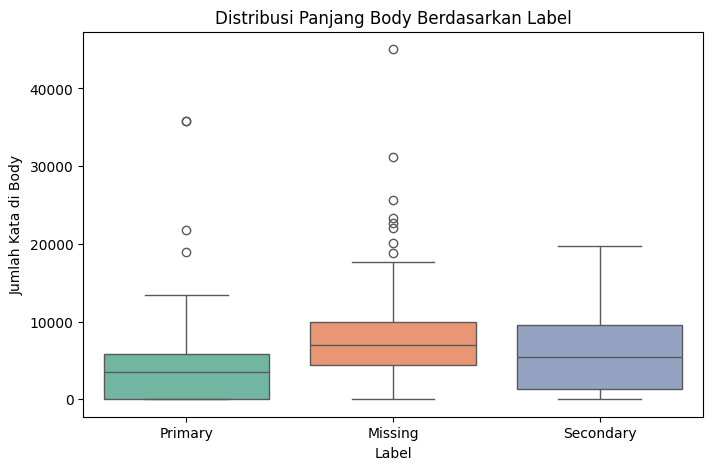

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ======================================
# 1. Load Dataset
# ======================================
train_text = pd.read_csv("parsed_articles_train_clean.csv")
train_labels = pd.read_csv("train_labels.csv")

# Gabungkan data
df = train_labels.merge(train_text, on="article_id")
df.fillna("unknown", inplace=True)

# Mapping label
label_map = {"Primary": 0, "Secondary": 1, "Missing": 2}
df["label"] = df["type"].map(label_map)

# Hitung panjang teks
df["abstract_length"] = df["abstract"].astype(str).apply(lambda x: len(x.split()))
df["body_length"] = df["body"].astype(str).apply(lambda x: len(x.split()))

# ======================================
# 2. Distribusi Label
# ======================================
plt.figure(figsize=(6, 4))
sns.countplot(x="type", data=df, palette="viridis")
plt.title("Distribusi Label")
plt.ylabel("Jumlah Artikel")
plt.xlabel("Tipe Label")
plt.show()
print("\nDistribusi Label:\n", df["type"].value_counts())

# ======================================
# 3. Distribusi Panjang Abstract vs Body (Pisah Subplot)
# ======================================
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Abstract
sns.histplot(df["abstract_length"], bins=50, color="purple", alpha=0.7, ax=axes[0])
axes[0].set_title("Distribusi Panjang Abstract")
axes[0].set_xlabel("Jumlah Kata")
axes[0].set_ylabel("Frekuensi")

# Body
sns.histplot(df["body_length"], bins=50, color="orange", alpha=0.7, ax=axes[1])
axes[1].set_title("Distribusi Panjang Body")
axes[1].set_xlabel("Jumlah Kata")

plt.tight_layout()
plt.show()

print("\nRata-rata Panjang per Label:")
print(df.groupby("type")[["abstract_length", "body_length"]].mean())

# ======================================
# 4. Distribusi Panjang Body Berdasarkan Label
# ======================================
plt.figure(figsize=(8, 5))
sns.boxplot(x="type", y="body_length", data=df, palette="Set2")
plt.title("Distribusi Panjang Body Berdasarkan Label")
plt.xlabel("Label")
plt.ylabel("Jumlah Kata di Body")
plt.show()


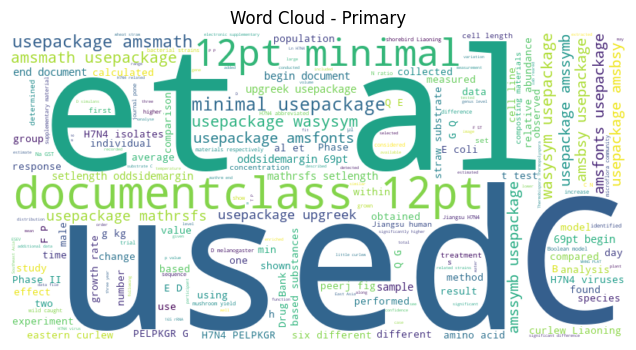

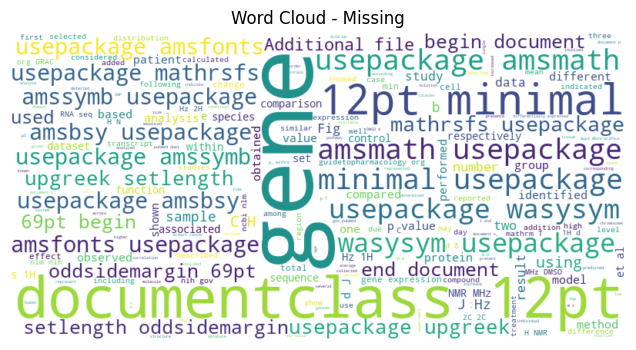

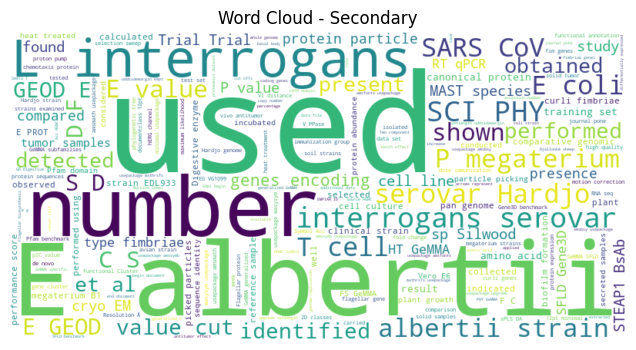

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# ======================================
# 1. Load Dataset
# ======================================
train_text = pd.read_csv("parsed_articles_train_clean.csv")
train_labels = pd.read_csv("train_labels.csv")

# Gabungkan data
df = train_labels.merge(train_text, on="article_id")
df.fillna("unknown", inplace=True)

# ======================================
# 2. Word Cloud per Label
# ======================================
for label in df["type"].unique():
    text = " ".join(df[df["type"] == label]["body"].astype(str).tolist())
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)

    plt.figure(figsize=(8, 4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud - {label}")
    plt.show()


In [28]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from transformers import AutoTokenizer, AutoModel

# ======================================
# 1. Load Dataset
# ======================================
train_text = pd.read_csv("parsed_articles_train_clean.csv")
test_text = pd.read_csv("parsed_articles_test_clean.csv")
train_labels = pd.read_csv("train_labels.csv")
test_labels = pd.read_csv("test_labels.csv")

df = train_labels.merge(train_text, on="article_id")
df.fillna("unknown", inplace=True)

# Mapping label
label_map = {"Primary": 0, "Secondary": 1, "Missing": 2}
reverse_map = {v: k for k, v in label_map.items()}
df["label"] = df["type"].map(label_map)
df = df.dropna(subset=["label"])

# ======================================
# 2. Variasi Missing
# ======================================
missing_df = df[df["label"] == 2]
non_missing_df = df[df["label"] != 2]

ratios = {"10%": 0.10, "30%": 0.30, "50%": 0.50, "full": 1.00}
datasets = {}

for name, frac in ratios.items():
    if frac < 1.0:
        missing_sample = missing_df.sample(frac=frac, random_state=42)
    else:
        missing_sample = missing_df.copy()
    
    df_variant = pd.concat([non_missing_df, missing_sample])
    df_variant = df_variant.sample(frac=1, random_state=42).reset_index(drop=True)
    
    print(f"\n📌 Variasi {name}: Total={len(df_variant)}, "
          f"Primary={sum(df_variant.label==0)}, "
          f"Secondary={sum(df_variant.label==1)}, "
          f"Missing={sum(df_variant.label==2)}")
    
    datasets[name] = df_variant

# ======================================
# 3. BERT Model
# ======================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased").to(device)
MAX_LEN = 128

def get_bert_embeddings(text_list):
    embeddings = []
    batch_size = 8
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = bert_model(**inputs)
        cls_embeddings = outputs.last_hidden_state.cpu().numpy()
        embeddings.append(cls_embeddings)
    return np.concatenate(embeddings, axis=0)

# ======================================
# 4. Training Loop & Submission
# ======================================
for name, df_variant in datasets.items():
    print(f"\n===== 🔥 Training untuk variasi {name} =====")

    # Gabungkan text
    df_variant["full_text"] = df_variant["abstract"].astype(str) + " " + df_variant["body"].astype(str)

    # Split data
    train_df, val_df = train_test_split(df_variant, test_size=0.3, stratify=df_variant["label"], random_state=42)

    X_train_texts = train_df["full_text"].tolist()
    X_val_texts = val_df["full_text"].tolist()
    y_train = to_categorical(train_df["label"].values, num_classes=3)
    y_val = to_categorical(val_df["label"].values, num_classes=3)

    print("✅ Generate BERT embeddings (train & val)...")
    X_train = get_bert_embeddings(X_train_texts)
    X_val = get_bert_embeddings(X_val_texts)

    # ======================================
    # 5. CNN + BiLSTM Model
    # ======================================
    model = Sequential([
        Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(MAX_LEN, 768)),
        MaxPooling1D(pool_size=2),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Hitung class weight
    from sklearn.utils.class_weight import compute_class_weight
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_df["label"]),
        y=train_df["label"]
    )
    class_weight_dict = dict(enumerate(class_weights))
    print("✅ Class Weights:", class_weight_dict)

    # Train model dengan class weight
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=5,
        batch_size=4,
        verbose=1,
        class_weight=class_weight_dict
    )

    # ======================================
    # 6. Evaluate
    # ======================================
    val_pred = model.predict(X_val)
    val_labels_pred = np.argmax(val_pred, axis=1)
    val_labels_true = np.argmax(y_val, axis=1)

    print("\n📊 Classification Report:")
    print(classification_report(val_labels_true, val_labels_pred, target_names=["Primary", "Secondary", "Missing"]))

    # ======================================
    # 7. Predict Test & Save Submission
    # ======================================
    print("✅ Generate BERT embeddings (test)...")
    test_text["full_text"] = test_text["abstract"].astype(str) + " " + test_text["body"].astype(str)
    X_test = get_bert_embeddings(test_text["full_text"].tolist())

    preds = model.predict(X_test)
    pred_labels = np.argmax(preds, axis=1)
    pred_types = [reverse_map[i] for i in pred_labels]

    submission = test_text[["article_id"]].copy()
    submission.insert(0, "row_id", range(1, len(submission) + 1))
    submission["type"] = pred_types

    submission = submission.merge(test_labels, on="article_id", how="left")
    submission = submission[["row_id", "article_id", "dataset_id", "type"]]

    file_name = f"submission_cnn_bilstm_bert_missing_{name}.csv"
    submission.to_csv(file_name, index=False)
    print(f"✅ Submission saved as {file_name}")



📌 Variasi 10%: Total=638, Primary=195, Secondary=423, Missing=20

📌 Variasi 30%: Total=677, Primary=195, Secondary=423, Missing=59

📌 Variasi 50%: Total=716, Primary=195, Secondary=423, Missing=98

📌 Variasi full: Total=815, Primary=195, Secondary=423, Missing=197

===== 🔥 Training untuk variasi 10% =====
✅ Generate BERT embeddings (train & val)...
✅ Class Weights: {0: 1.0931372549019607, 1: 0.5022522522522522, 2: 10.619047619047619}
Epoch 1/5
112/112 [==============================] - 15s 66ms/step - loss: 1.0494 - accuracy: 0.5987 - val_loss: 0.5087 - val_accuracy: 0.7656
Epoch 2/5
112/112 [==============================] - 5s 48ms/step - loss: 0.7629 - accuracy: 0.7108 - val_loss: 0.6477 - val_accuracy: 0.6562
Epoch 3/5
112/112 [==============================] - 6s 49ms/step - loss: 0.4898 - accuracy: 0.7758 - val_loss: 0.3872 - val_accuracy: 0.7865
Epoch 4/5
112/112 [==============================] - 5s 46ms/step - loss: 0.2178 - accuracy: 0.8587 - val_loss: 0.4390 - val_accuracy: